In [12]:
from py2neo import *
import timeit
import pandas as pd

In [13]:
graph = Graph(user='neo4j',password ='123')  

In [16]:
'''
SQ1  
--------
Query Command:
match (q_u:User)-[r1:questioned]->(question:Post{id:'1'})<-[r2:belong]-(answer:Post)<-[r3:answered]-(a_u:User)
return q_u.CreationDate,q_u.DisplayName,q_u.UpVotes,q_u.DownVotes,
a_u.CreationDate,a_u.DisplayName,a_u.UpVotes,a_u.DownVotes

'''
%time pd.DataFrame(graph.run("match (q_u:User)-[r1:questioned]->(question:Post{id:'1'})<-[r2:belong]-(answer:Post)<-[r3:answered]-(a_u:User) return q_u.CreationDate,q_u.DisplayName,q_u.UpVotes,q_u.DownVotes, a_u.CreationDate,a_u.DisplayName,a_u.UpVotes,a_u.DownVotes").data())

CPU times: user 4.35 ms, sys: 4.05 ms, total: 8.4 ms
Wall time: 306 ms


,a_u.CreationDate,a_u.DisplayName,a_u.DownVotes,a_u.UpVotes,q_u.CreationDate,q_u.DisplayName,q_u.DownVotes,q_u.UpVotes
0,2016-08-02T15:38:36.723,kenorb,3,559,2016-08-02T15:38:36.723,kenorb,3,559
1,2016-08-02T16:49:08.133,Dawny33,4,104,2016-08-02T15:38:36.723,kenorb,3,559
2,2016-08-02T15:38:21.100,Franck Dernoncourt,2,15,2016-08-02T15:38:36.723,kenorb,3,559


In [19]:
'''
SQ2 6ms
-------
Neo4j query command
match (q:Post{PostTypeId:'1'}) 
where "deep-network" in q.Tags 
return q order by q.ViewCount DESC limit 1

The results get from neo4j browser since the py2neo will return due to the double quotes 
'''
graph.run("match (q:Post{PostTypeId:'1'}) where 'deep-network' in q.Tags return q order by q.ViewCount DESC limit 1").data()


[{'q': (_5353:Post {AcceptedAnswerId: '250', CreationDate: datetime('2016-08-02T17:05:27.590000000'), OwnerUserId: '8', PostTypeId: '1', Tags: ['convolutional-neural-networks', 'image-recognition', 'deep-network', 'computer-vision'], Title: 'How is it possible that deep neural networks are so easily fooled?', ViewCount: 3173, id: '92'})}]

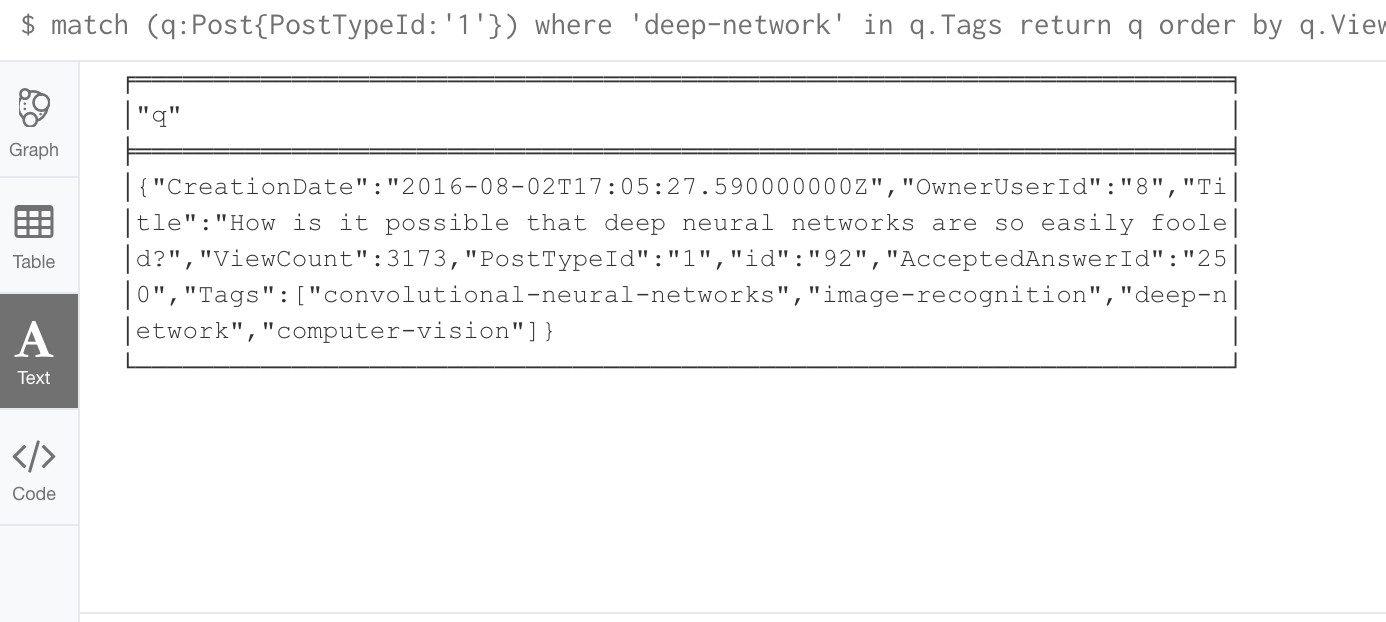

In [21]:
'''
AQ6 13ms
----------
Neo4j query command
match (u:User{id:'4398'})-[*2..3]->(a:Post)<--(u1:User) 
where u1.id<>'4398' 
return u1.id as coAuthor,count(Distinct a) as coopTime order by coopTime DESC limit 5
'''
# Given person: id = 4398
%time pd.DataFrame(graph.run("match (u:User{id:'4398'})-[*2..3]->(a:Post)<--(u1:User) where u1.id<>'4398' return u1.id as CoAuthor,count(Distinct a) as coopTime order by coopTime DESC limit 5").data())


CPU times: user 2.18 ms, sys: 1.26 ms, total: 3.43 ms
Wall time: 196 ms


,CoAuthor,coopTime
0,1671,5
1,11571,4
2,9161,4
3,4302,3
4,6019,3


[AQ5] Discover questions with arguable accepted answer.

In [28]:
'''
AQ5 26ms
-----------
Neo4j query
match (questionVote:Vote{VoteTypeId:'2'})-->(ques:Post{PostTypeId:'1'})
        with ques,count(questionVote) as quesVote
        where quesVote > 10
        with ques as q
match (allAnswerVote:Vote{VoteTypeId:'2'})-->(allAnswer:Post{PostTypeId:'2'})-[:belong]->(q)-[:accept]->(acceptedAnswer:Post{PostTypeId:'2'})  
        with q,q.id as questionId,allAnswer.id as allAnswer,count(allAnswerVote) as numVote, acceptedAnswer.id as acceptedId 
        order by questionId,numVote DESC 
        with questionId,collect(numVote)[0] as highestUpvote,collect(allAnswer)[0] as HighestAnswer,collect(acceptedId)[0] as acceptedAnswerId 
match (p:Post{PostTypeId:'2'})<--(acceptVote:Vote{VoteTypeId:'2'})
        where p.id=acceptedAnswerId
        with questionId,highestUpvote,acceptedAnswerId,count(acceptVote) as AcceptedUpvote
        where AcceptedUpvote<highestUpvote
return questionId,highestUpvote,AcceptedUpvote
'''
#define the threshold as 5
pd.DataFrame(graph.run("match (questionVote:Vote{VoteTypeId:'2'})-->(ques:Post{PostTypeId:'1'}) with ques,count(questionVote) as quesVote where quesVote > 5 with ques as q match (allAnswerVote:Vote{VoteTypeId:'2'})-->(allAnswer:Post{PostTypeId:'2'})-[:belong]->(q)-[:accept]->(acceptedAnswer:Post{PostTypeId:'2'}) with q,q.id as questionId,allAnswer.id as allAnswer,count(allAnswerVote) as numVote, acceptedAnswer.id as acceptedId  order by questionId,numVote DESC with questionId,collect(numVote)[0] as highestUpvote,collect(allAnswer)[0] as HighestAnswer,collect(acceptedId)[0] as acceptedAnswerId match (p:Post{PostTypeId:'2'})<--(acceptVote:Vote{VoteTypeId:'2'}) where p.id=acceptedAnswerId with questionId,highestUpvote,acceptedAnswerId,count(acceptVote) as AcceptedUpvote where AcceptedUpvote<highestUpvote return questionId,highestUpvote,AcceptedUpvote").data())

,AcceptedUpvote,highestUpvote,questionId
0,2,3,7247
1,2,3,5964
2,3,5,191
3,8,9,148
4,2,4,3903
5,3,6,2477
6,2,3,2381
7,3,4,248
8,1,3,3488
9,7,14,7555


In [268]:
'''
AQ4
-------
Neo4j query: 
        match (u:User{id:'4398'})-[:answered]->(p:Post{PostTypeId:'2'})<-[:accept]-(q:Post{PostTypeId:'1'})-->(t:Tag) 
        where q.CreationDate<datetime('2018-08-30T00:00:00') 
        with t.id as tag,count(p) as answeredTimes order by answeredTimes DESC limit 4 
        with collect(tag) as relatedTag 
        match (q:Post{PostTypeId:'1'})-->(t:Tag) 
        where NOT exists(q.AcceptedAnswerId) and t.id in relatedTag and q.CreationDate<datetime('2018-08-30T00:00:00') 
        return Distinct q.Title as title,q.id as id,q.CreationDate as date order by date DESC limit 5
Index
        User nodes: id
'''
#suppose id as '4398'
pd.DataFrame(graph.run("match (u:User{id:'4398'})-[:answered]->(p:Post{PostTypeId:'2'})<-[:accept]-(q:Post{PostTypeId:'1'})-->(t:Tag) where q.CreationDate<datetime('2018-08-30T00:00:00') with t.id as tag,count(p) as answeredTimes order by answeredTimes DESC limit 4 with collect(tag) as relatedTag match (q:Post{PostTypeId:'1'})-->(t:Tag) where NOT exists(q.AcceptedAnswerId) and t.id in relatedTag and q.CreationDate<datetime('2018-08-30T00:00:00') return Distinct q.Title as title,q.id as id,q.CreationDate as date order by date DESC limit 5").data())



,date,id,title
0,2018-08-29T16:04:16.113Z,7755,How to implement a constrained action space in...
1,2018-08-28T00:17:55.907Z,7737,creating application to transform human comput...
2,2018-08-27T18:41:56.223Z,7736,"In imitation learning, do you simply inject op..."
3,2018-08-27T16:13:16.433Z,7734,AI composing music
4,2018-08-27T10:18:17.893Z,7727,How is it possible to teach a neural network t...


In [33]:
'''
AQ1  46ms
----------
Neo4j Query Command

match (t:Tag)<--(q:Post{PostTypeId:'1'})<--(a:Post{PostTypeId:'2'}) where t.id in [\"deep-network\",\"machine-learning\",\"turing-test\"] 
with t,duration.between(q.CreationDate,a.CreationDate) as answerDuration,q 
with t,min(answerDuration) as shortestAnsTime,min(q) as easiest_question 
return t,shortestAnsTime,easiest_question

'''
pd.DataFrame(graph.run("match (t:Tag)<--(q:Post{PostTypeId:'1'})<--(a:Post{PostTypeId:'2'}) where t.id in [\"deep-network\",\"machine-learning\",\"turing-test\"] \
                with t,duration.between(q.CreationDate,a.CreationDate) as answerDuration,q \
                with t,min(answerDuration) as shortestAnsTime,min(q) as easiest_question \
                return easiest_question.id as id,easiest_question.Title as title").data())

,id,title
0,35,What is the difference between artificial inte...
1,15,"Is the Turing Test, or any of its variants, a ..."
2,4,How to find the optimal number of neurons per ...


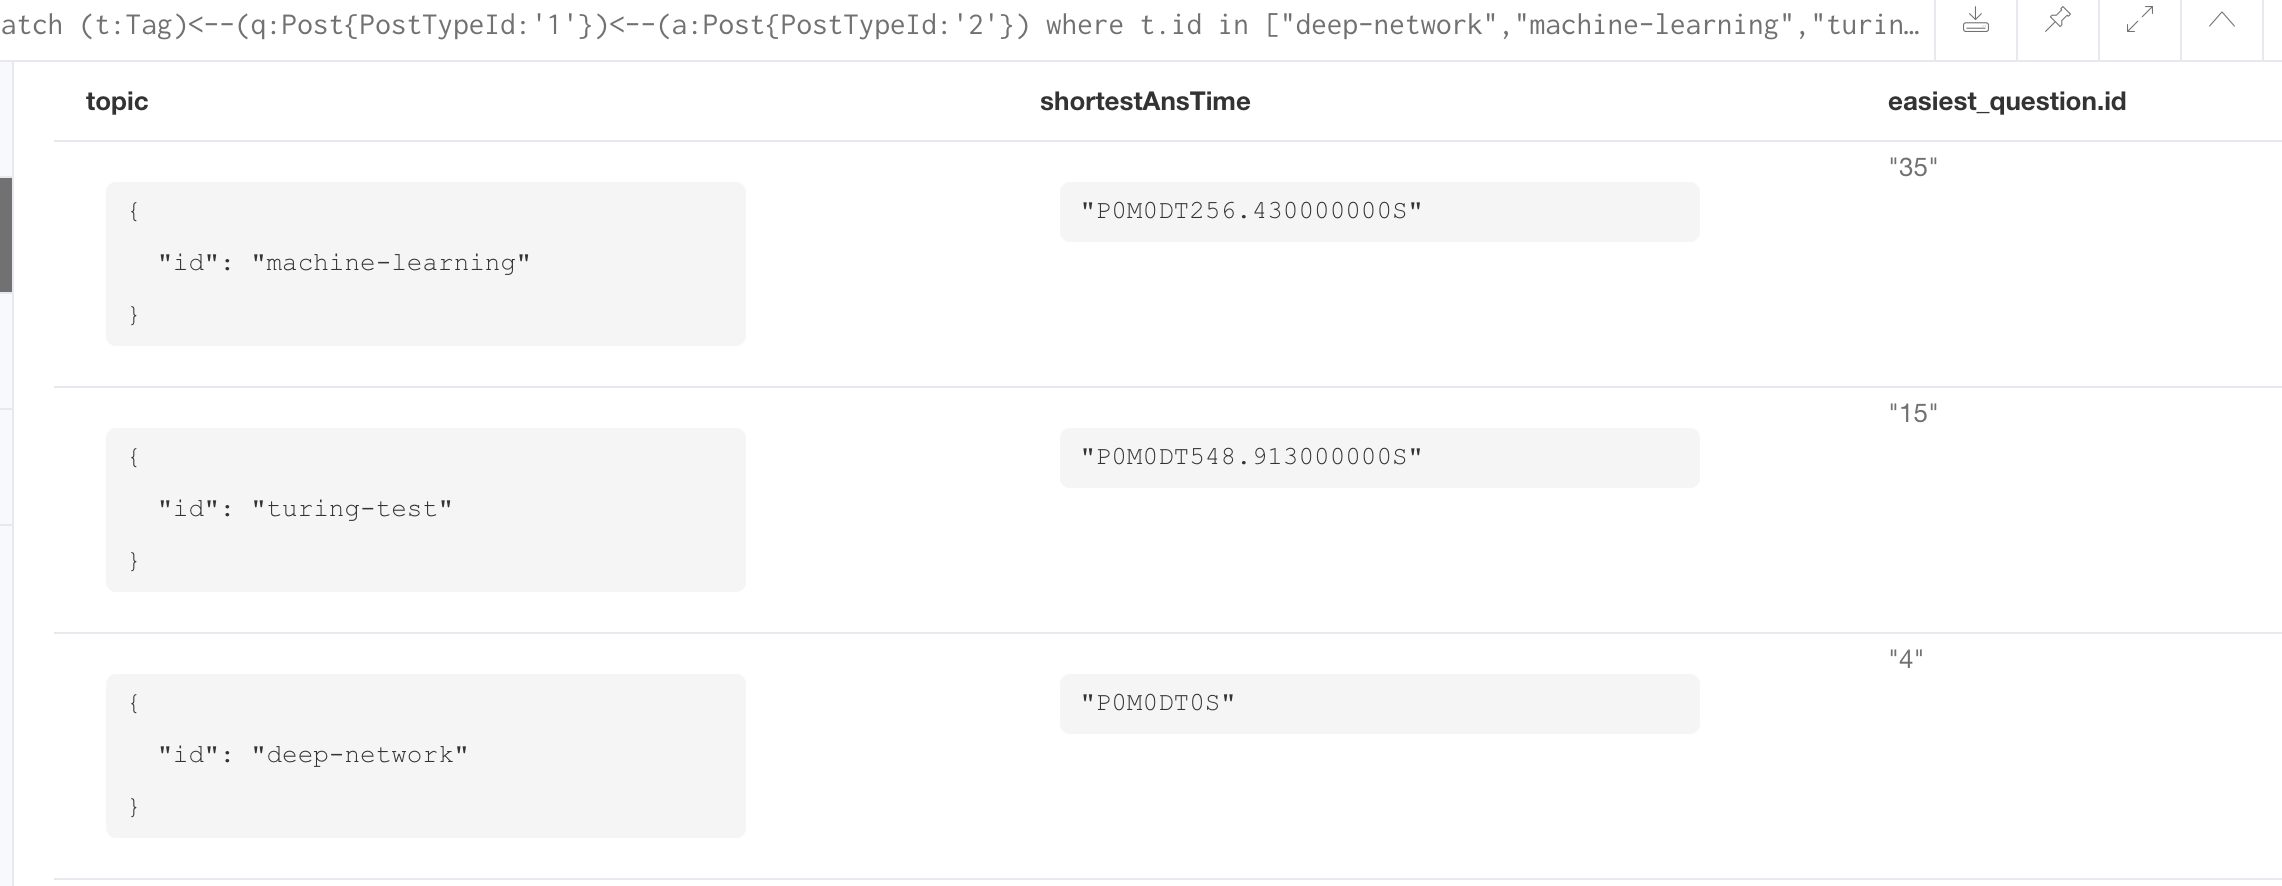

In [231]:
#AQ2   based on sample
pd.DataFrame(graph.run("match (u:User)-->(p:Post)-->(t:Tag) \
where p.CreationDate>datetime('2018-08-01T00:00:00') and p.CreationDate<datetime('2018-08-31T00:00:00') \
with t,u \
return t as topic,count(DISTINCT u) as userNumber order by userNumber DESC limit 5").data())

,topic,userNumber
0,{'id': 'neural-networks'},65
1,{'id': 'machine-learning'},44
2,{'id': 'deep-learning'},39
3,{'id': 'reinforcement-learning'},28
4,{'id': 'convolutional-neural-networks'},24


In [40]:
'''
AQ3
------
Neo4j Quey Command

match (t:Tag)<--(q:Post{PostTypeId:'1'})-[:accept]->(a:Post)<--(u:User)
where t.id="deep-learning"
with t,count(a) as acceptedAnswerNUM,u
order by acceptedAnswerNUM DESC limit 1
with t,acceptedAnswerNUM,u
match (t)<--(q:Post{PostTypeId:'1'})-[:accept]->(a:Post)<--(u)
return q.id as id,q.Title as title order by id

'''

graph.run("match (t:Tag)<--(q:Post{PostTypeId:'1'})-[:accept]->(a:Post)<--(u:User)\
where t.id=\"deep-learning\"\
with t,count(a) as acceptedAnswerNUM,u\
order by acceptedAnswerNUM DESC limit 1\
with t,acceptedAnswerNUM,u\
match (t)<--(q:Post{PostTypeId:'1'})-[:accept]->(a:Post)<--(u)\
return q.id as id,q.Title as title order by id").data()

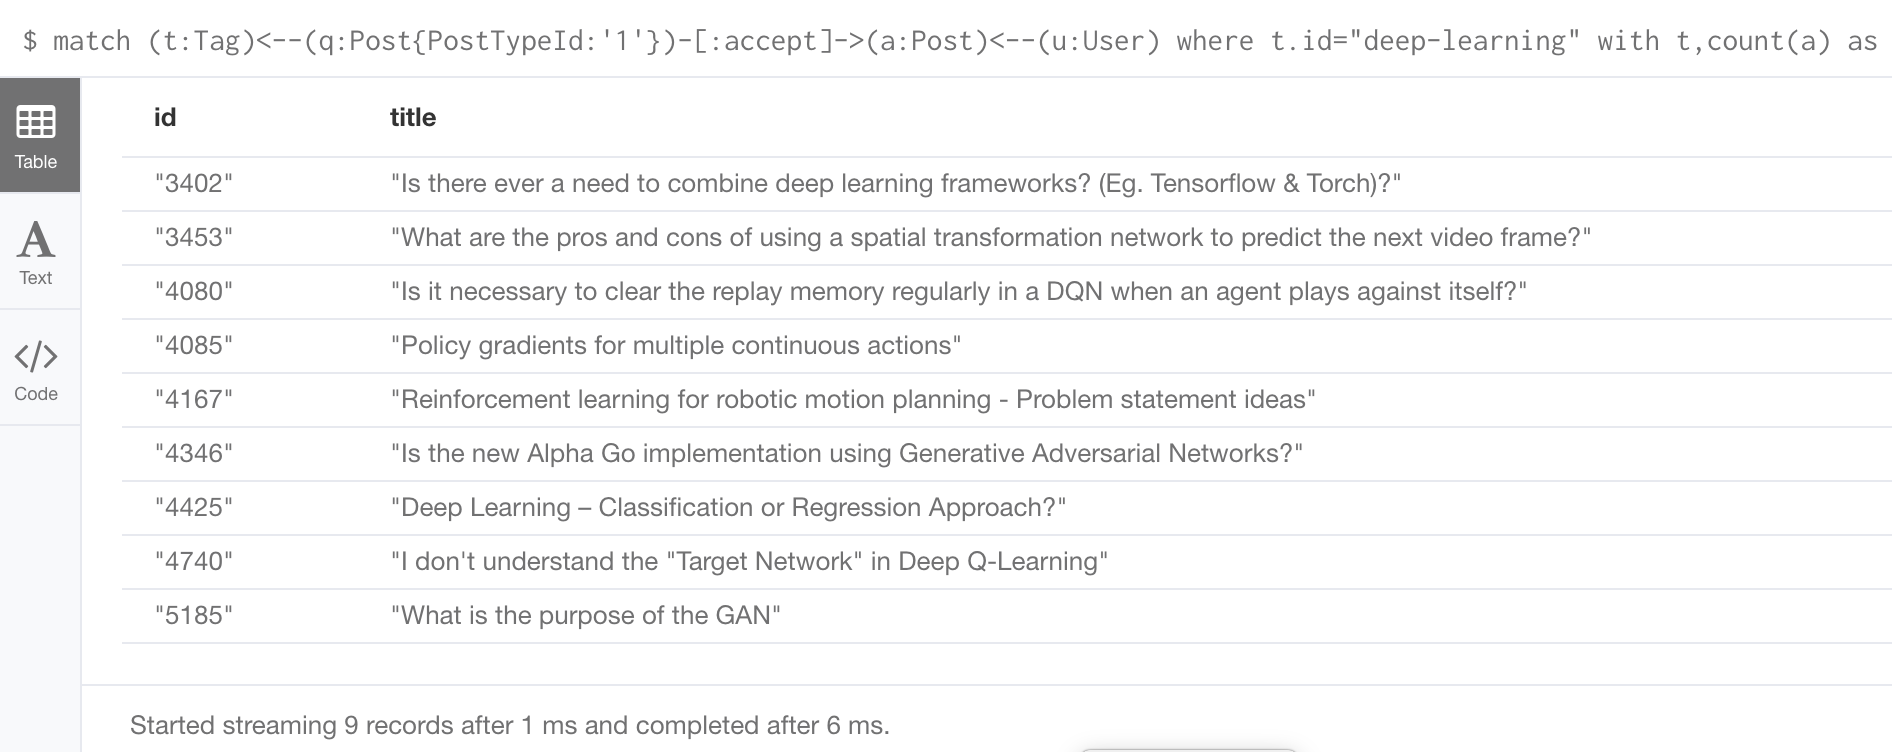